Datos cargados correctamente.
Dimensiones: (144, 9)
Entrenamiento: 120 horas
Test (Validación): 24 horas

Entrenando modelo...
[0]	validation_0-rmse:1431007.37083	validation_1-rmse:1533583.79156
[100]	validation_0-rmse:572930.09592	validation_1-rmse:601083.85357
[200]	validation_0-rmse:239013.84586	validation_1-rmse:265132.77355
[300]	validation_0-rmse:106023.00622	validation_1-rmse:149842.18673
[400]	validation_0-rmse:50884.82487	validation_1-rmse:119135.77226
[500]	validation_0-rmse:26478.20340	validation_1-rmse:110422.23227
[600]	validation_0-rmse:14396.77514	validation_1-rmse:109037.17611
[604]	validation_0-rmse:14074.32241	validation_1-rmse:109063.92024

--- Resultados ---
MAE (Error Medio Absoluto): 76,292.38
Esto significa que, en promedio, nos equivocamos por 1.66%


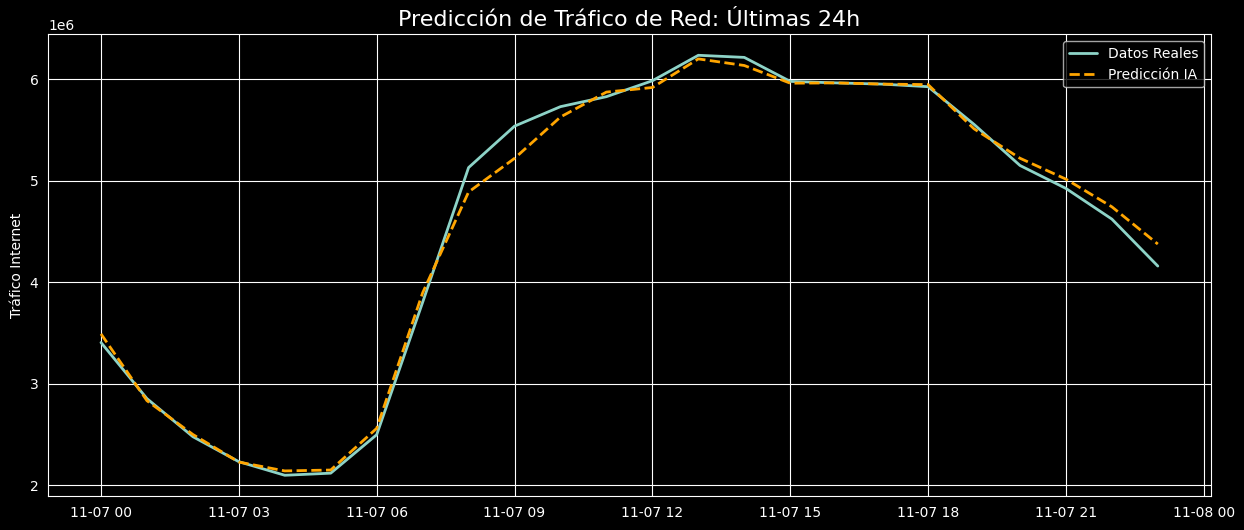

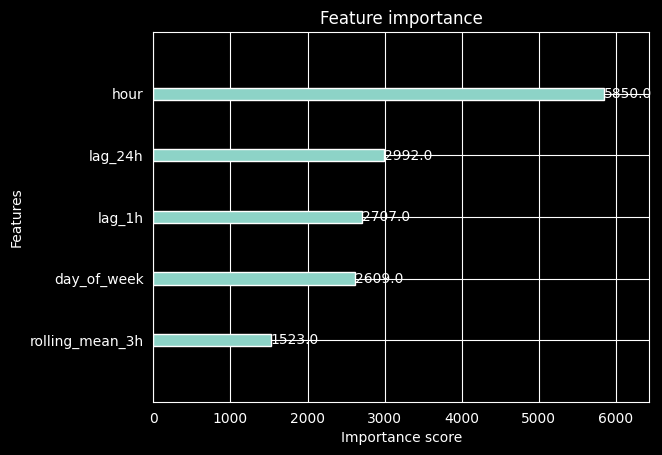

In [1]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# --- IMPORTACIÓN ---
try:
    # Cargamos el archivo generado en el paso 02
    df_model_ready = pd.read_pickle("df_features.pkl")
    print("Datos cargados correctamente.")
    print(f"Dimensiones: {df_model_ready.shape}")
except FileNotFoundError:
    print("⚠ Error: Ejecuta primero el notebook 02_preprocessing.ipynb")


# Asumiendo que 'df_model_ready' viene del paso anterior
df = df_model_ready.copy()

# --- 1. División Temporal (Time Series Split) ---
# NO usamos train_test_split aleatorio. Eso sería hacer trampa (Data Leakage).
# Cortamos: Entrenamos con los primeros días, probamos con el ÚLTIMO día (7 Nov).

split_date = '2013-11-06 23:00:00'

train = df.loc[df['datetime'] <= split_date].copy()
test = df.loc[df['datetime'] > split_date].copy()

print(f"Entrenamiento: {train.shape[0]} horas")
print(f"Test (Validación): {test.shape[0]} horas")

# --- 2. Definir Features (X) y Target (y) ---
features = ['hour', 'day_of_week', 'is_weekend', 'lag_1h', 'lag_24h', 'rolling_mean_3h']
target = 'internet'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

# --- 3. Entrenamiento del Modelo (XGBoost) ---
# Usamos parámetros robustos por defecto
model = xgb.XGBRegressor(
    n_estimators=1000,   # Número de árboles
    learning_rate=0.01,  # Velocidad de aprendizaje (lento pero seguro)
    early_stopping_rounds=50, # Parar si no mejora para evitar Overfitting
    n_jobs=-1            # Usar todos los núcleos de la CPU
)

print("\nEntrenando modelo...")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100  # Imprimir progreso cada 100 árboles
)

# --- 4. Predicción y Evaluación ---
prediction = model.predict(X_test)

# Añadimos la predicción al dataframe de test para visualizar
test['prediction'] = prediction

# Métricas de Error
mae = mean_absolute_error(y_test, prediction)
print(f"\n--- Resultados ---")
print(f"MAE (Error Medio Absoluto): {mae:,.2f}")
print(f"Esto significa que, en promedio, nos equivocamos por {mae/y_test.mean()*100:.2f}%")

# --- 5. Visualización: Realidad vs IA ---
plt.figure(figsize=(15, 6))
plt.plot(test['datetime'], test['internet'], label='Datos Reales', linewidth=2)
plt.plot(test['datetime'], test['prediction'], label='Predicción IA', linestyle='--', color='orange', linewidth=2)
plt.title('Predicción de Tráfico de Red: Últimas 24h', fontsize=16)
plt.ylabel('Tráfico Internet')
plt.legend()
plt.grid(True)
plt.show()

# --- 6. Feature Importance (¿Qué aprendió el modelo?) ---
xgb.plot_importance(model, importance_type='weight')
plt.show()

In [3]:
# --- EXPORTAR MODELO (CORREGIDO) ---
# Usamos .get_booster() para evitar el error de "_estimator_type"
# Esto guarda el cerebro puro de XGBoost.
model.get_booster().save_model("xgb_traffic_model.json")

print("Modelo guardado exitosamente como 'xgb_traffic_model.json'")

Modelo guardado exitosamente como 'xgb_traffic_model.json'
